In [74]:
#Library imports
import re
import os
import sys
import shutil
import time
import math
import fnmatch
import random
import warnings
import numpy as np
import pandas as pd
import scipy.stats as scs
import urllib.request
import seaborn as sns
import matplotlib.pyplot as plt

from collections import OrderedDict

import scipy.stats as scs

import fiona
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
from pyproj import Proj
import geoplot as gplt
import geoplot.crs as gcrs

from sklearn.neighbors import BallTree

# Allows access to scripts and modules relative to the parent directory.
parent = os.getcwd()
sys.path.append(os.path.join(parent, "functions"))

# Project specific user driven functions
from cleaning_functions import *
from eda_functions import *

# My open source reusable user driven function repository.
from random_lumberjacks.src.random_lumberjacks.cleaning.cleaning_functions import *
from random_lumberjacks.src.random_lumberjacks.model.model_classes import *
from random_lumberjacks.src.random_lumberjacks.visualization.visualization_functions import *

#Notebook arguments
%matplotlib inline

In [2]:
water_final = pd.read_csv("data/Water_FINAL.csv", low_memory = False)
water_dict = pd.read_csv("data/CBP_water_dictionary_final.csv")

In [3]:
water_final.head()

,Unnamed: 0,Unnamed: 0.1,Agency,BiasPC,CloudCover,Comments,Cruise,Database,Date,FieldActivityEventType,...,Weather Conditions Yesterday,WindDirection,WindSpeed,state,Point,HUC12_,HUCNAME_,FIPS_,COUNTY_,STATE_
0,0,2143,NaN,NaN,NaN,NaN,NaN,CMC,04/28/2018,NaN,...,NaN,W,1-10 knots,MD,POINT (-75.93002800000002 39.480194),20600020206,Bohemia River,24015,Cecil County,MD
1,1,2145,NaN,NaN,NaN,NaN,NaN,CMC,04/28/2018,NaN,...,NaN,W,1-10 knots,MD,POINT (-75.902528 39.480444),20600020206,Bohemia River,24015,Cecil County,MD
2,2,2147,NaN,NaN,NaN,NaN,NaN,CMC,04/28/2018,NaN,...,NaN,S,1-10 knots,MD,POINT (-75.873639 39.466889),20600020206,Bohemia River,24015,Cecil County,MD
3,3,2151,NaN,NaN,NaN,NaN,NaN,CMC,04/28/2018,NaN,...,NaN,SW,1-10 knots,MD,POINT (-75.854444 39.454),20600020206,Bohemia River,24015,Cecil County,MD
4,4,2152,NaN,NaN,NaN,NaN,NaN,CMC,04/28/2018,NaN,...,NaN,SW,1-10 knots,MD,POINT (-75.84352800000001 39.463667),20600020206,Bohemia River,24015,Cecil County,MD


In [5]:
def preliminary_cleaning(orig_df):
    
    df = orig_df.copy()
    # Combining the Date and Time parameters into a single Datetime Object
    df["Date"] = df["Date"]+"-"+df["Time"]
    df["Date"] = pd.to_datetime(df["Date"])
    
    # The Station identifiers are unique between the two datasets so they can be merged into a single column.
    df['Station'] = np.where(df['Station'].isnull(), df['StationCode'], df['Station'])
    
    # It will be easier to compare observed tide data by combining them into the same column first.
    df["Tidal Stage"] = df["Tidal Stage"].map(standardize_CMC_tidal_strings)
    df['TideStage'] = np.where(df['TideStage'].isnull(), df['Tidal Stage'], df['TideStage'])
    
    # Regex cleanup of weather conditions field.
    df["Weather Conditions Today"]=df["Weather Conditions Today"].map(standardize_CMC_weather_strings)
    df["Weather Conditions Yesterday"]=df["Weather Conditions Yesterday"].map(standardize_CMC_weather_strings)
    
    # Regex cleanup of wind speed field.
    df["WindSpeed"] = df["WindSpeed"].map(standardize_CMC_wind_strings)
    
    # Case cleaning of the Wind Direction Field.
    df["WindDirection"] = df["WindDirection"].map(standardize_CMC_wind_dir_strings)
    
    # Regex cleanup of the Water Surfaces field
    df["Water Surfaces"] = df["Water Surfaces"].map(standardize_CMC_water_surf_strings)
    
    # Dropping indexes, redundancies, and qualitative data that won't be used in model.
    df.drop(columns = ["Unnamed: 0", "Unnamed: 0.1", "FieldActivityRemark", "PrecisionPC", "Comments",
                       "Time", "Other Comments", "Other Conditions", "StationCode", "StationName",
                       "Tidal Stage", "ModifiedDate", "Water Color", "Water Color Description",
                       "Water Odor", "Water Odor Description", "state", 'COUNTY_', 'STATE_', "Lab",
                       "BiasPC"], inplace=True)
    
    # Reducing observations to parameters for model
    df = df[(df["ParameterName_CBP"]=="WATER TEMPERATURE DEG") | (df["ParameterName_CBP"]=="SPECIFIC CONDUCTIVITY") |
        (df["ParameterName_CBP"]=="AIR TEMPERATURE DEG")]
    
    return df
df = preliminary_cleaning(water_final)

Before flattening and removing columns, the following user created functions make it easy to determine whether
maintining the parameter subgroups is worth the complexity it will introduce.

In [6]:
full_value_comparison(df, "ParameterName_CBP", "Parameter")

WATER TEMPERATURE DEG
There are 13 unique values with 0 nan values making up 0.0%
388565-WTEMP --90.23%
11760-WT.3 --2.73%
8763-WT.10 --2.03%
4616-WT.4 --1.07%
4299-WT.1 --1.00%
4151-WT.2 --0.96%
3673-WT.6 --0.85%
2351-WT.13 --0.55%
751-WT.9 --0.17%
723-WT.8 --0.17%
602-WT.12 --0.14%
355-WT.5 --0.08%
29-WT.7 --0.01%

SPECIFIC CONDUCTIVITY
There are 6 unique values with 0 nan values making up 0.0%
11794-CO.1 --54.34%
4634-CO.5 --21.35%
2978-CO.8 --13.72%
2068-CO.4 --9.53%
150-CO.9 --0.69%
82-CO.2 --0.38%

AIR TEMPERATURE DEG
There are 9 unique values with 0 nan values making up 0.0%
4802-AT.6 --28.71%
4072-AT.2 --24.35%
2258-AT.1 --13.50%
1808-AT.3 --10.81%
1794-AT.10 --10.73%
776-AT.9 --4.64%
725-AT.4 --4.34%
364-AT.5 --2.18%
125-AT.11 --0.75%



Aside from a string formatting discrepancy, 4 units are shared across the 3 main groups of parameters. They are distinct enough to identify that the conductivity values have two possible units.

In [7]:
full_value_counts(df, "Unit")

There are 4 unique values with 0 nan values making up 0.0%
388565-DEG C --82.84%
58797-deg C --12.53%
21624-uS/cm --4.61%
82-mS/cm --0.02%


It is already defined in the CO.2 (conductivity) parameter which will need to be converted to match the rest
of the data.

In [8]:
df[df["Unit"]=="mS/cm"]["Parameter"].equals(df[df["Parameter"]=="CO.2"]["Parameter"])

True

Converting it to the the proper units shows an enormous effect size between the two groups. Without more information,

In [9]:
(df[df["Parameter"]=="CO.2"]["MeasureValue"]*1000).describe()

count       82.000000
mean      9729.512195
std       2311.539438
min       6950.000000
25%       8060.000000
50%       8770.000000
75%      12565.000000
max      13900.000000
Name: MeasureValue, dtype: float64

In [10]:
df[(df["Parameter"]!="CO.2") & (df["ParameterName_CBP"]=="SPECIFIC CONDUCTIVITY")]["MeasureValue"].describe()

count    21624.000000
mean       248.263076
std        398.445798
min          0.030000
25%         47.537500
50%        153.000000
75%        318.000000
max      15449.000000
Name: MeasureValue, dtype: float64

In [11]:
df[df["Parameter"]=="CO.2"][["Date", "Database", "Station", "Latitude", "Longitude"]].set_index("Date")

,Database,Station,Latitude,Longitude
Date,,,,
2018-05-03 08:36:00,CMC,SCC.MAC,38.9732,-76.4924
2018-05-03 08:36:00,CMC,SCC.MAC,38.9732,-76.4924
2018-05-03 08:36:00,CMC,SCC.MAC,38.9732,-76.4924
2018-05-03 08:46:00,CMC,SCC.SUP,38.9724,-76.4893
2018-05-03 08:46:00,CMC,SCC.SUP,38.9724,-76.4893
...,...,...,...,...
2018-05-31 09:33:00,CMC,SCC.EYC,38.9753,-76.4782
2018-05-31 09:33:00,CMC,SCC.EYC,38.9753,-76.4782
2018-05-31 09:49:00,CMC,SCC.MOS,38.9753,-76.4837


In [12]:
full_value_counts(df[df["Parameter"]=="CO.2"], "Station")

There are 9 unique values with 0 nan values making up 0.0%
10-SCC.HC --12.20%
9-SCC.MOWC --10.98%
9-SCC.SUP --10.98%
9-SCC.EYC --10.98%
9-SCC.MSW --10.98%
9-SCC.MSM --10.98%
9-SCC.MOS --10.98%
9-SCC.MAC --10.98%
9-SCC.HW --10.98%


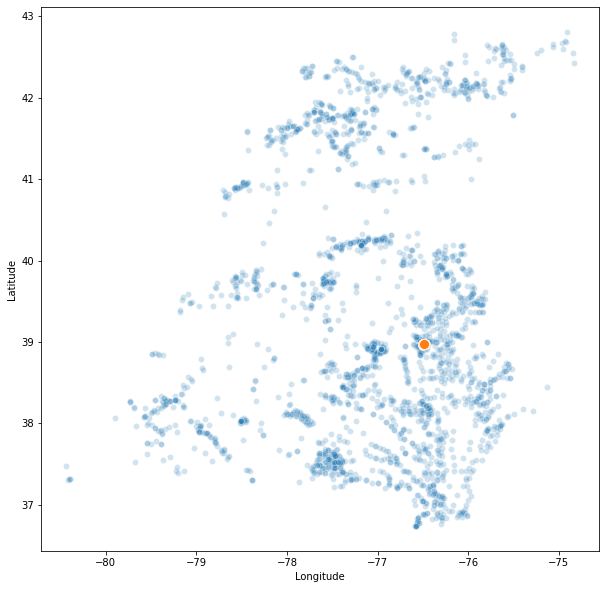

In [13]:
plt.figure(figsize=(10,10))
sns.scatterplot(x="Longitude", y="Latitude", data=df[df["Parameter"]!="CO.2"].groupby("Station").first(), alpha=.2)
sns.scatterplot(x="Longitude", y="Latitude", data=df[df["Parameter"]=="CO.2"].groupby("Station").first(), **{"s":100})


The tiny point on the map(after scaling for visibility) indicates that these samples are in very close proximity to each other, compared to the rest of the data. Further investigation revealed the closest points having much different values, but they weren't that close comparatively. It may be worth revisiting to improve the model later.

In [5]:
df[df["Parameter"]=="CO.2"]["MeasureValue"] *= 1000

/opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [6]:
def unnest_cmc_cbp_dataframe(data):

    df = data.copy()
    # Prior unit conversion
    df["MeasureValue"] = np.where(df['Parameter'] == "CO.2", df["MeasureValue"] * 1000, df["MeasureValue"])

    # Creating new columns to break out the nested measurements
    for new_col in df["ParameterName_CBP"].unique():
        df[new_col] = np.where(df['ParameterName_CBP'] == new_col, df["MeasureValue"], np.nan)

    # Removing the original columns.
    df.drop(columns = ["Parameter", "ParameterName_CMC", "ParameterName_CBP", 'MeasureValue', 'Unit'], inplace=True)
    
    # Reduces observations to the interval of the target variable
    df = extract_timespan(df, "Date", "SPECIFIC CONDUCTIVITY")

    # Using these three values in a groupby, the dataframe will be tightened a bit without loss.
    groups = ["Date", "Station", "SampleDepth"]

    # Prevents Missing Sample Depth From Being dropped.
    df["SampleDepth"] = df["SampleDepth"].fillna(-999)

    # Flattens overlapping data removing nans
    df = df.groupby(groups).first().reset_index()

    #Returns sample depth back to original nans.
    df["SampleDepth"] = np.where(df["SampleDepth"]==-999, np.nan, df["SampleDepth"])
    
    return df

df = unnest_cmc_cbp_dataframe(df)

Upon examining the data for water temperature, the histogram indicates a major outlier.

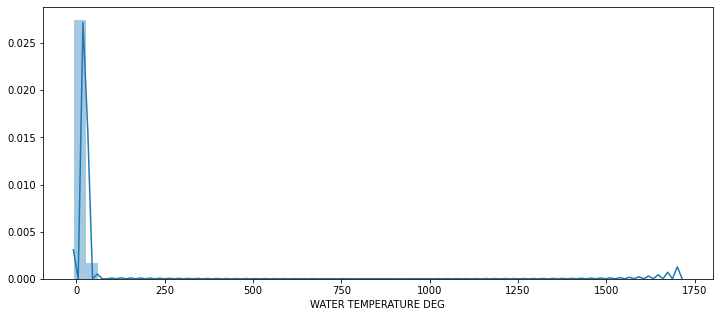

In [6]:
plt.figure(figsize=(12,5))
sns.distplot(df["WATER TEMPERATURE DEG"])

Further examination from anything that could be unusually high revealed what seems to be mistakes from wrong temperature units and missing decimals.

In [7]:
df[df["WATER TEMPERATURE DEG"]> 42][["Database", "Method", "Date", "SampleDepth", "Station", "WATER TEMPERATURE DEG"]]

,Database,Method,Date,SampleDepth,Station,WATER TEMPERATURE DEG
12298,CBP,F01,2005-10-24 12:05:00,0.5,XGG9992,55.8
14733,CBP,F01,2005-12-12 08:39:00,0.5,ET4.1,47.0
14734,CBP,F01,2005-12-12 08:39:00,1.0,ET4.1,48.0
14735,CBP,F01,2005-12-12 08:39:00,2.0,ET4.1,45.0
14736,CBP,F01,2005-12-12 08:39:00,3.0,ET4.1,45.0
14737,CBP,F01,2005-12-12 08:39:00,4.0,ET4.1,45.0
14738,CBP,F01,2005-12-12 08:39:00,4.9,ET4.1,47.0
14739,CBP,F01,2005-12-12 08:39:00,5.0,ET4.1,47.0
55976,CMC,NaN,2007-05-08 12:00:00,0.3,LCCD.MILL2,68.0
63823,CMC,NaN,2007-07-09 12:00:00,0.3,LCCD.MILL2,77.0


Examining the adjacent temperature readings of the biggest outlier confirms the missing decimal point.

In [8]:
mbj004 = df[df["Station"]=="MJB004.30"].set_index("Date").reset_index()
mbj004[mbj004["Date"]=="2010-04-13 09:18:00"][["Database", "Method", "Date", "SampleDepth", "Station", "WATER TEMPERATURE DEG"]]

,Database,Method,Date,SampleDepth,Station,WATER TEMPERATURE DEG
6,CBP,F01,2010-04-13 09:18:00,1.0,MJB004.30,17.13
7,CBP,F01,2010-04-13 09:18:00,2.0,MJB004.30,17.12
8,CBP,F01,2010-04-13 09:18:00,3.0,MJB004.30,1712.00
9,CBP,F01,2010-04-13 09:18:00,4.0,MJB004.30,16.96
10,CBP,F01,2010-04-13 09:18:00,5.0,MJB004.30,16.82
11,CBP,F01,2010-04-13 09:18:00,6.0,MJB004.30,16.83


The monthly averages converted to Fahrenheit are a strong match for the readings above 40C.

In [9]:
month_avg = df.copy()
month_avg["WATER TEMPERATURE DEG"] = np.where(month_avg["WATER TEMPERATURE DEG"] == 1712.00, 17.12, month_avg["WATER TEMPERATURE DEG"])
month_avg["Month"] = pd.DatetimeIndex(month_avg["Date"]).month
month_avg.groupby("Month")["WATER TEMPERATURE DEG"].mean()*9/5+32

Month
1     40.803143
2     40.260925
3     45.345459
4     55.397578
5     64.700133
6     74.244333
7     79.672651
8     79.932677
9     74.794016
10    65.236741
11    53.677520
12    45.560752
Name: WATER TEMPERATURE DEG, dtype: float64

In [10]:
month_avg.groupby("Month")["WATER TEMPERATURE DEG"].describe()[["25%", "75%"]]

,25%,75%
Month,,
1,2.80000,6.70
2,2.70000,6.15
3,5.34000,9.30
4,10.60000,15.30
5,16.10000,20.10
6,21.80000,25.50
7,25.39025,28.20
8,25.64000,28.10
9,22.70000,25.50


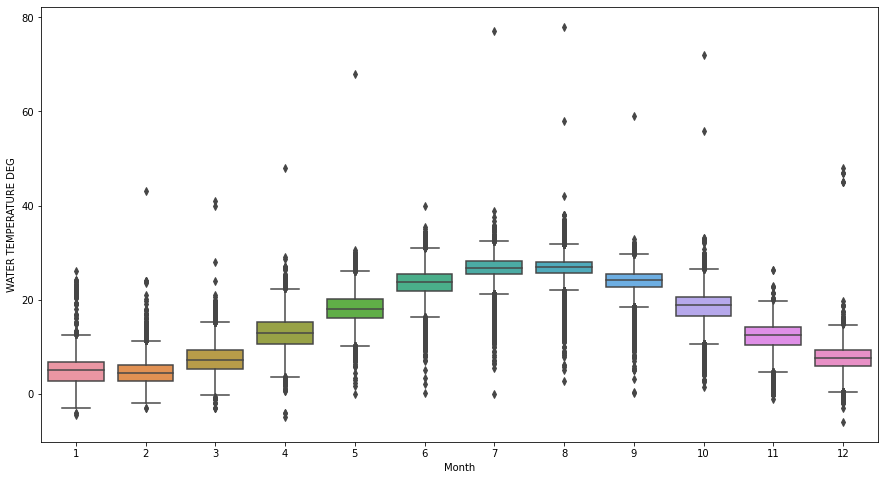

In [11]:
plt.figure(figsize = (15,8))
sns.boxplot(x="Month", y="WATER TEMPERATURE DEG", orient="v", data=month_avg)
    
plt.show()

In [7]:
def create_month_quartile_table(data, column):
    # Creates the quartiles for Celcius values
    prefix = ["Q1", "Q3"]
    suffix = ["_C", "_F"]
    df = data.groupby("Month")[column].describe()[["25%", "75%"]].copy()
    df.columns = [prefix[0], prefix[1]]
    df = pd.concat([df.add_suffix(suffix[0]), (df*9/5+ 32).add_suffix(suffix[1])], axis=1)
    return df


def fix_wrong_temperature_units_values(df, column, table, coef1, coef2):
    """In order for a unit swap to be detected the value must be both outside of range for values within
    assumed unit, but inside of range of alternate unit. Two coeficients that get applied to the IQR
    of each range control the threshold. As units converge, detection automatically becomes more difficult."""
    
    for month in np.arange(1,13):
        q1c, q3c, q1f, q3f = table.loc[month]
        deltac, deltaf = coef1 * (q3c - q1c), coef2 * (q3f-q1f)
        lowc, highc = q1c - deltac, q3c + deltac
        lowf, highf = q1f - deltaf, q3f + deltaf
        conversion = lambda x: (x-32) * 5/9
        df[column] = np.where((df["Month"]==month) & ((df[column]<=lowc) | (df[column]>=highc)) &
                              (df[column]>=lowf) & (df[column]<=highf), conversion(df[column]), df[column])
    return df


def fix_wrong_temperature_units(data, column, coef1, coef2):
    df = data.copy()
    df["Month"] = pd.DatetimeIndex(df["Date"]).month
    stats = create_month_quartile_table(df, column)
    df = fix_wrong_temperature_units_values(df, column, stats, coef1, coef2)
    df.drop(columns=["Month"], inplace=True)
    return df

In [8]:
def clean_cmc_cbp_dataframe(data):
    df = data.copy()
    df["WATER TEMPERATURE DEG"] = np.where(df["WATER TEMPERATURE DEG"] == 1712.00, 17.12, df["WATER TEMPERATURE DEG"])
    df = fix_wrong_temperature_units(df, "WATER TEMPERATURE DEG", 4, 1.5)
    df = fix_wrong_temperature_units(df, "AIR TEMPERATURE DEG", 4, 1.5)
    
    # Aggregating the sample depth data since units have been resolved.
    groups = ["Date", "Station"]
    cols = df.columns.difference(groups, sort=False)
    
    #Takes the median of samples if the datatype is a float (All measured values were). Otherwise takes the first item.
    functions = ["median" if df[col].dtype=="float" else "first" for col in cols]
    agg_list = dict(zip(cols,functions))
    df = df.groupby(groups).agg(agg_list).reset_index()
    
    #Removing addtional columns
    df.drop(columns = ['SampleDepth', 'SampleId', 'SampleReplicateType', 'SampleType', "Problem",
                       "Qualifier"], inplace=True)
    return df

In [9]:
df = clean_cmc_cbp_dataframe(df)

In [9]:
df.to_pickle("data/cbp_cmc.pickle")

# Integrating NOAA Data

In [13]:
cbp_cmc_df = pd.read_pickle("data/cbp_cmc.pickle")
noaa_df = pd.read_pickle("data/noaa_match.pickle")
noaa_locations_df = pd.read_pickle("data/noaa_location_key.pickle")

To join these dataframes together it makes sense to analyze the time resolution that both of these contain for their observations. It is clear that even with the 100x observation count in the noaa dataframe, they will have to be resampled as these datapoints are spread over different stations. Because of the sparse nature in the CBP/CMC dataframe, there likely won't be much advantage in going more granular than on an hourly level.

(121224, 44)
(10097291, 31)


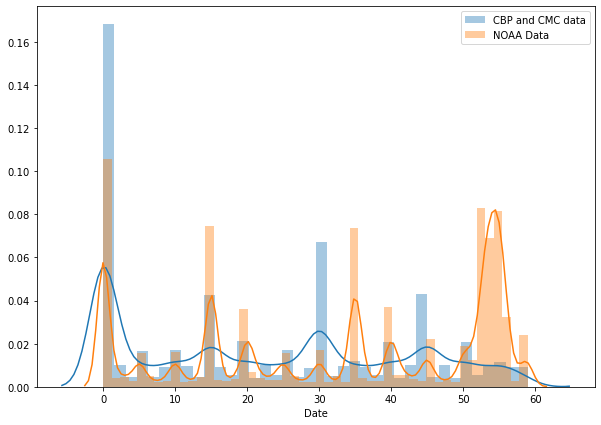

In [3]:
plt.figure(figsize=(10,7))
sns.distplot(cbp_cmc_df["Date"].dt.minute, label="CBP and CMC data")
sns.distplot(noaa_df["Date"].dt.minute, label="NOAA Data")
plt.legend()
print(cbp_cmc_df.shape)
print(noaa_df.shape)
plt.show()

Since the NOAA data contains multiple observations, I leveraged a user created function to change data flagged as suspect to nans. This will allow nonsuspect data to take precedence when flattening to hourly and if it is still present, it will allow the next station neighbor to take precedence when filling na values

In [14]:
noaa_qc = remove_suspect_noaa_data(noaa_df, 'Wind_Dir_Q', ['Wind_Dir', 'Wind_Type'], ["2", "3", "6", "7"])
noaa_qc = remove_suspect_noaa_data(noaa_qc, 'Wind_Speed_Q', ['Wind_Speed'], ["2", "3", "6", "7"])
noaa_qc = remove_suspect_noaa_data(noaa_qc, 'Air Temperature_Q', ['Air Temperature'], ["2", "3", "6", "7"])
noaa_qc = remove_suspect_noaa_data(noaa_qc, 'Air_Pressure_Q', ['Air_Pressure_Q'], ["2", "3", "6", "7"])

In [15]:
noaa_hourly = reduce_time_resolution_in_multindex(noaa_qc, 'Date', "H", ["USAF_ID", "NCEI_WBAN_ID"])
cbp_cmc_hourly = reduce_time_resolution_in_multindex(cbp_cmc_df, 'Date', "H", ["Station"])

In [5]:
# Mapping the degrees to values that can be compared in the correlation matrix.
degree_map = {'N':0, 'E':90, "S":180, "W":270, "NE":45, "SE":135, "SW":225, "NW":315,
              "NNE": 22.5, "ENE": 67.5, "ESE":112.5, "SSE": 157.5, "SSW":202.5, "WSW":247.5, "WNW": 292.5, "NNW":337.5}

# The wind speed is an even less precise conversion.
speed_map = {'1 To 10 Knots':5, '0 To 1 Knot':1, 'Calm':0, '>30 To 40 Knots':35, '20 To 30 Knots':25, '10 To 20 Knots':15, 'Above 40 Knots':45}
meters_second_to_knots = 1.943844

examine_corr_noaa = noaa_hourly[['Date', 'USAF_ID', 'NCEI_WBAN_ID','Wind_Dir', 'Wind_Speed', 'Air Temperature', 'Air_Pressure']].copy()
examine_corr_cbp_cmc = cbp_cmc_hourly[['Date', 'Station', 'WindDirection', 'WindSpeed', 'AIR TEMPERATURE DEG', 'Pressure']].copy()

# Converting the WindDirection to their sin and cosine values to prevent the 0 to 360 degree jump.
examine_corr_cbp_cmc['WindDirection'] = examine_corr_cbp_cmc['WindDirection'].map(degree_map)
examine_corr_cbp_cmc['cmc_wind_sin'] = examine_corr_cbp_cmc['WindDirection'].map(lambda x: math.sin(math.radians(x)))
examine_corr_cbp_cmc['cmc_wind_cos'] = examine_corr_cbp_cmc['WindDirection'].map(lambda x: math.cos(math.radians(x)))
examine_corr_noaa['noaa_wind_sin'] = examine_corr_noaa['Wind_Dir'].map(lambda x: math.sin(math.radians(x)))
examine_corr_noaa['noaa_wind_cos'] = examine_corr_noaa['Wind_Dir'].map(lambda x: math.cos(math.radians(x)))

# A rough categorical to quantitative transformation for the correlation matrix.
examine_corr_cbp_cmc["WindSpeed"] = examine_corr_cbp_cmc["WindSpeed"].map(speed_map)
examine_corr_noaa["Wind_Speed"] = examine_corr_noaa["Wind_Speed"] * meters_second_to_knots

examine_corr = examine_corr_cbp_cmc.merge(noaa_locations_df, how="left", on="Station").drop(columns=["Latitude", "Longitude", "noaa_dist_mi1",
                                                                                                     "USAF_id2", "WBAN_id2", "noaa_dist_mi2",
                                                                                                     "USAF_id3", "WBAN_id3", "noaa_dist_mi3"]).copy()
#Fixing bug from incompatible datatypes.
examine_corr["WBAN_id1"] = examine_corr["WBAN_id1"].astype("object").map(lambda x: str(x))

#Merging the datasets together and trimming for correlation matrix.
examine_corr = examine_corr.merge(examine_corr_noaa, how="inner", left_on=["Date", "USAF_id1", "WBAN_id1"],
                                  right_on=["Date", 'USAF_ID', 'NCEI_WBAN_ID']).drop(columns=["WindDirection", "Wind_Dir"])

Examining the heatmap, there appears to be a very strong correlation Between the temperature values. The next most significant reading is the wind temperature, which considering the categorical values is a strong match. The negative correlation in pressure indicates something being wrong between the two as they should be correlated positively if measuring the same parameter. Wind speed has less correlation which partially could be a function of distance, but the possible categorical values in the cbp_cmc data are even more sparse than direction. Since wind could be introducing pollutants from the greater airshed, I opted to replace it with the noaa data as well.

<Figure size 1080x720 with 0 Axes>

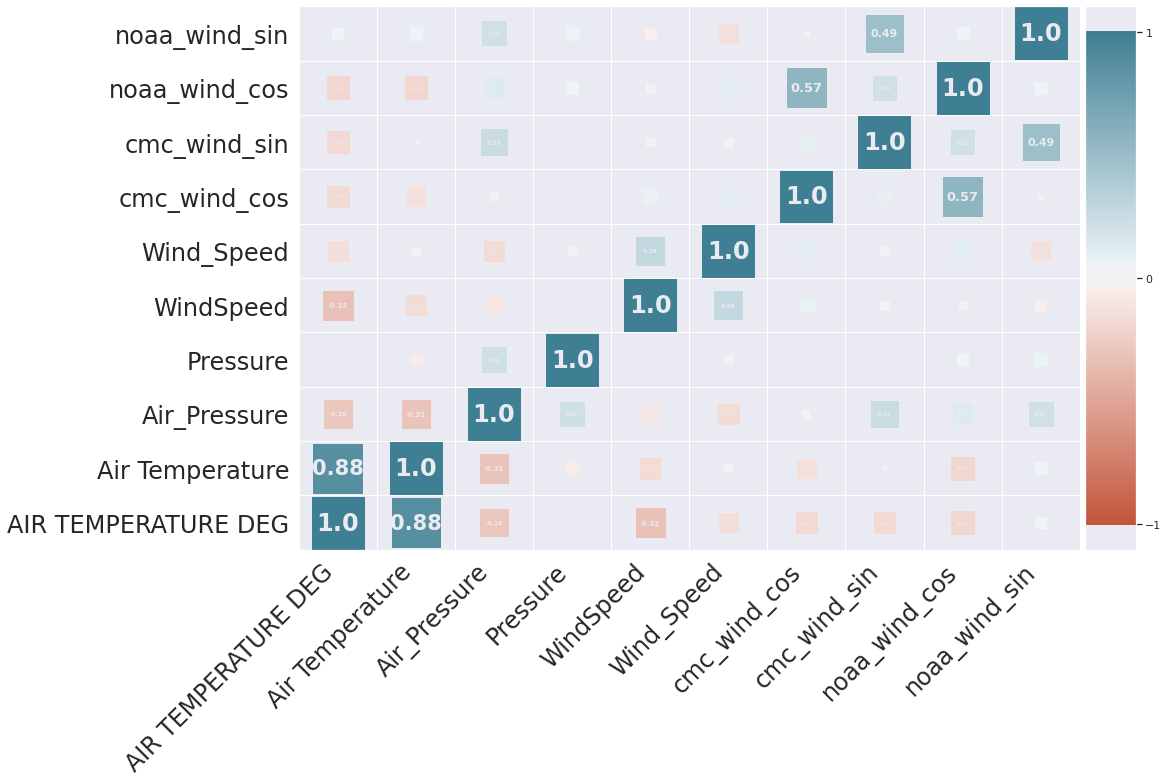

In [6]:
dynamic_heatmap(examine_corr, examine_corr.columns, fontsize=24, annot=True, palette=None, figsize=(15, 10), squaresize=2700)

In [7]:
examine_corr.corr().iloc[0:5,5:]

,Wind_Speed,Air Temperature,Air_Pressure,noaa_wind_sin,noaa_wind_cos
WindSpeed,0.285232,-0.155767,-0.103774,-0.043055,0.023624
AIR TEMPERATURE DEG,-0.142194,0.880327,-0.281932,0.045056,-0.189855
Pressure,-0.030872,-0.051789,0.218374,0.063518,0.049567
cmc_wind_sin,-0.028587,-0.003664,0.253768,0.485551,0.211032
cmc_wind_cos,0.101515,-0.131685,-0.023295,-0.011795,0.568012


To reduce the amount of observations to those that recorded specific conductivity, I will first try to fill missing information from neighbors (from both databases) within a 5 mile radius. The NOAA neihgbors list can reach distances to almost 60 miles away, so finding any overlapping CBP/CMC points in close proximity first, would provide better accuracy.

In [95]:
cbp_cmc_overlap = cbp_cmc_hourly.groupby("Date").count().reset_index()
cbp_cmc_overlap = cbp_cmc_overlap[(cbp_cmc_overlap["Station"]>1) & (cbp_cmc_overlap["SPECIFIC CONDUCTIVITY"]>0)]["Date"]

cbp_cmc_cond_coords = cbp_cmc_hourly[(cbp_cmc_hourly["Date"].isin(cbp_cmc_overlap)) &
                                     (cbp_cmc_hourly["SPECIFIC CONDUCTIVITY"].isna()==False)][["Station", "Latitude", "Longitude"]]

cbp_cmc_overlap = cbp_cmc_hourly[cbp_cmc_hourly["Date"].isin(cbp_cmc_overlap)]["Station"]
cbp_cmc_all_coords = cbp_cmc_hourly[cbp_cmc_hourly["Station"].isin(cbp_cmc_overlap)][["Station", "Latitude", "Longitude"]]

cbp_cmc_cond_coords = cbp_cmc_cond_coords.groupby("Station").first().reset_index()
cbp_cmc_all_coords = cbp_cmc_all_coords.groupby("Station").first().reset_index()

In [96]:
tree = BallTree(np.deg2rad(cbp_cmc_all_coords[["Latitude", "Longitude"]].values), metric='haversine')

In [128]:
# These stations can be relatively close together. Choosing this value for k ensures that the minimum distance
# between rows will reach 5 miles.
k = cbp_cmc_all_coords.shape[0]//10
distances, indices = tree.query(np.deg2rad(cbp_cmc_cond_coords[["Latitude", "Longitude"]]), k = k)
indices = pd.DataFrame(indices, columns = [f"Near_Station{i}" for i in np.arange(0,k)])
distances = pd.DataFrame(distances*3959, columns = [f"dist_mi{i}" for i in np.arange(0,k)])

In [129]:
indices = indices.drop(columns="Near_Station0")
distances = distances.drop(columns="dist_mi0")
cbp_cmc_neighbors = cbp_cmc_cond_coords.drop(columns=["Latitude", "Longitude"]).copy()
for i, column in enumerate(indices.columns):
    cbp_cmc_neighbors[column] = indices[column].map(lambda x: cbp_cmc_all_coords["Station"][x])
    cbp_cmc_neighbors["Dist_"+column] = distances[f"dist_mi{i+1}"]

In [130]:
cbp_cmc_neighbors

,Station,Near_Station1,Dist_Near_Station1,Near_Station2,Dist_Near_Station2,Near_Station3,Dist_Near_Station3,Near_Station4,Dist_Near_Station4,Near_Station5,...,Near_Station217,Dist_Near_Station217,Near_Station218,Dist_Near_Station218,Near_Station219,Dist_Near_Station219,Near_Station220,Dist_Near_Station220,Near_Station221,Dist_Near_Station221
0,ACWA.ANT0.2,ANT0047,2.356099,ANT0044,2.356099,POT1830,3.468102,01618100,6.611963,ACWA.BEA0.1,...,ANA05,54.822997,KNG02,54.938683,ANA29,54.959257,PMS29,54.973093,ANA19,54.973715
1,ACWA.ANT20A,ACWA.BEA0.1,0.251462,ACWA.LAN0.1,2.533155,ACWA.LBC2.1,3.524888,ANT0203,3.890036,ACWA.BEA8.0B,...,CCCD.CONCRE32.47,56.841687,CCSTA.CONCRE32.47,56.841687,PWSWCD.PWSWCD_DQ_PL41_19_CMP35,57.071224,PWSWCD.PWSWCD_DQ_PL41_19_CMP34,57.082905,GUN0258,57.217750
2,ACWA.ANT40,ANT0366,0.091561,WQN0511,0.109376,AWA.EBM,0.623239,AWA.IBR,0.665174,AWA.FP,...,RCM0111,57.747977,RCR01,58.123515,WQN0214,58.458208,TPO01,58.612480,01608500,58.797061
3,ACWA.BEA0.1,ACWA.ANT20A,0.251462,ACWA.LAN0.1,2.735940,ACWA.LBC2.1,3.570919,ANT0203,4.136521,ACWA.BEA8.0B,...,PWSWCD.PWSWCD_DQ_PL41_19_CMP34,56.831573,LRA.LT10,56.943459,CCCD.CONCRE32.47,57.021118,CCSTA.CONCRE32.47,57.021118,PWSWCD.PWSWCD_PR_PL34_19_CMP19,57.034174
4,ACWA.BEA8.0B,ACWA.LBC2.1,1.838030,ACWA.LAN0.1,2.531568,ANT0203,3.624329,ACWA.ANT20A,4.661091,ACWA.BEA0.1,...,CCCD.HOGRUN0.98,55.977401,CCSTA.HOGRUN0.98,55.977401,ARK.PR.4,56.029473,PAT0176,56.136858,YMNA.MillCreek83,56.183968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
964,YMNA.KreutzCreekEmigPark,YCST.KRECRE8.67,0.037715,YMNA.KreutzCreekCampSecurity,2.724417,YMNA.KreutzCreekWindsorRd,3.741750,YMNA.CodorusCreekSpringetts,4.313733,WQN0286,...,XJF0821,47.987922,XJH6868,48.116548,XJH5342,48.263886,MDR0038,48.332668,CCCD.BURRUN1.38,48.442882
965,YMNA.KreutzCreekWindsorRd,YMNA.KreutzCreekCampSecurity,2.063086,YMNA.MillCreekCBW,2.583158,YMNA.KreutzCreekEmigPark,3.741750,YCST.KRECRE8.67,3.759187,YCST.TYLRUN1.01,...,XIE7136,46.030520,XIE7135,46.032063,CCCD.BRARUN0.01,46.147196,CCCD.CONCRE59.72,46.158306,WT3.1,46.190484
966,YMNA.MillCreek83,YCST.MILCRE0.09,0.024171,YMNA.TribCodorusBallField,2.061555,YCST.CODCRE12.16,2.108604,YCST.CODCRE12.39,2.219022,YCST.TYLRUN0.50,...,AWA.GP,46.732808,XKH2870,46.791011,AWA.HB,46.795494,AWA.AS,46.804675,AWA.SR,46.806296
967,YMNA.MillCreekCBW,YCST.TYLRUN1.01,2.125160,YCST.TYLRUN0.50,2.570162,YMNA.KreutzCreekWindsorRd,2.583158,YMNA.KreutzCreekCampSecurity,2.669310,YCST.CODCRE12.16,...,XJG2340,45.851062,XKH0375,45.922224,ENERWA.CTN,46.017608,ENERWA.HSP,46.029314,AWA.MASP,46.030155


In [124]:
cbp_cmc_hourly.columns

Index(['Date', 'Station', 'Agency', 'CloudCover', 'Cruise', 'Database',
       'FieldActivityEventType', 'FlowStage', 'GaugeHeight', 'GroupCode',
       'HUC12', 'Latitude', 'Layer', 'Longitude', 'LowerPycnocline', 'Method',
       'PrecipType', 'Pressure', 'Program', 'Project', 'Rainfall',
       'Rainfall Within 24 Hours', 'Rainfall Within 48 Hours', 'Sea State',
       'Source', 'Stream Flow', 'TideStage', 'TierLevel', 'TotalDepth',
       'UpperPycnocline', 'Water Surfaces', 'WaveHeight',
       'Weather Conditions Day Before Yesterday', 'Weather Conditions Today',
       'Weather Conditions Yesterday', 'WindDirection', 'WindSpeed', 'Point',
       'HUC12_', 'HUCNAME_', 'FIPS_', 'WATER TEMPERATURE DEG',
       'SPECIFIC CONDUCTIVITY', 'AIR TEMPERATURE DEG'],
      dtype='object')

In [5]:
k = 4
column_list = ['Date', 'USAF_ID', 'NCEI_WBAN_ID', 'Data Source', 'Latitude', 'Longitude', 'Code', 'Quality_Control',
               'Wind_Dir', 'Wind_Dir_Q', 'Wind_Type', 'Wind_Speed', 'Wind_Speed_Q', 'Air Temperature', 'Air Temperature_Q']

combined_hourly = cbp_cmc_hourly.merge(noaa_locations_df, how="left", on="Station").copy()

for i in range(1, k+1):
    #Fixing bug from incompatible datatypes.
    combined_hourly[f"WBAN_id{i}"] = combined_hourly[f"WBAN_id{i}"].astype("object").map(lambda x: str(x))
    combined_hourly = combined_hourly.merge(noaa_hourly[column_list], how="left", left_on=["Date", f"USAF_id{i}", f"WBAN_id{i}"],
                                  right_on=["Date", 'USAF_ID', 'NCEI_WBAN_ID'], suffixes=(None,i))

In [6]:
cbp_cmc_hourly_fill = cbp_cmc_hourly.copy()
for i in range(1,k+1):
    if i == 1:
        neighbor = 'Air Temperature'
    else:
        neighbor = f'Air Temperature{i}'
    cbp_cmc_hourly_fill['AIR TEMPERATURE DEG'] = np.where(cbp_cmc_hourly_fill['AIR TEMPERATURE DEG'].isna(),
                                                          combined_hourly[neighbor], cbp_cmc_hourly_fill['AIR TEMPERATURE DEG'])

In [15]:
cbp_cmc_df[cbp_cmc_df["SPECIFIC CONDUCTIVITY"].isna()]

,Date,Station,Agency,CloudCover,Cruise,Database,FieldActivityEventType,FlowStage,GaugeHeight,GroupCode,...,Weather Conditions Yesterday,WindDirection,WindSpeed,Point,HUC12_,HUCNAME_,FIPS_,WATER TEMPERATURE DEG,SPECIFIC CONDUCTIVITY,AIR TEMPERATURE DEG
3,2001-06-27 12:00:00,LRA.LT1,NaN,NaN,NaN,CMC,NaN,NaN,NaN,LRA,...,NaN,NaN,NaN,POINT (-77.18536999999998 40.17663),20503050404,Letort Spring Run,42041,12.5,NaN,NaN
4,2001-06-27 12:00:00,LRA.LT10,NaN,NaN,NaN,CMC,NaN,NaN,NaN,LRA,...,NaN,NaN,NaN,POINT (-77.14193 40.23487),20503050404,Letort Spring Run,42041,18.5,NaN,NaN
5,2001-06-27 12:00:00,LRA.LT2,NaN,NaN,NaN,CMC,NaN,NaN,NaN,LRA,...,NaN,NaN,NaN,POINT (-77.18507 40.17667),20503050404,Letort Spring Run,42041,13.2,NaN,NaN
6,2001-06-27 12:00:00,LRA.LT3,NaN,NaN,NaN,CMC,NaN,NaN,NaN,LRA,...,NaN,NaN,NaN,POINT (-77.18692 40.17999),20503050404,Letort Spring Run,42041,12.8,NaN,NaN
7,2001-06-27 12:00:00,LRA.LT4,NaN,NaN,NaN,CMC,NaN,NaN,NaN,LRA,...,NaN,NaN,NaN,POINT (-77.18606 40.18844),20503050404,Letort Spring Run,42041,14.3,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121215,2020-07-01 11:27:00,ARK.AR.6,NaN,NaN,NaN,CMC,NaN,NaN,NaN,ARK,...,NaN,NaN,NaN,POINT (-77.0102 38.86535),20700100204,Lower Anacostia River,11001,27.0,NaN,28.0
121216,2020-07-01 12:15:00,ARK.AR.7,NaN,NaN,NaN,CMC,NaN,NaN,NaN,ARK,...,NaN,NaN,NaN,POINT (-77.02460000000001 38.8774),20700100103,Pimmit Run-Potomac River,11001,27.3,NaN,27.0
121219,2020-07-05 09:10:00,PVMN.RS1,NaN,Clear,NaN,CMC,NaN,NaN,NaN,PVMN,...,NaN,NW,1 To 10 Knots,POINT (-76.43044 37.13467),20801080101,Poquoson River-Frontal Chesapeake Bay,51199,26.0,NaN,26.5
121220,2020-07-05 09:40:00,PVMN.GC1,NaN,Clear,NaN,CMC,NaN,NaN,NaN,PVMN,...,NaN,NaN,Calm,POINT (-76.42586999999997 37.19409),20801080101,Poquoson River-Frontal Chesapeake Bay,51199,25.5,NaN,28.0


In [10]:
cbp_cmc_hourly_fill

,Date,Station,Agency,CloudCover,Cruise,Database,FieldActivityEventType,FlowStage,GaugeHeight,GroupCode,...,Weather Conditions Yesterday,WindDirection,WindSpeed,Point,HUC12_,HUCNAME_,FIPS_,WATER TEMPERATURE DEG,SPECIFIC CONDUCTIVITY,AIR TEMPERATURE DEG
0,2001-06-20 09:00:00,LCCD.LC3,NaN,NaN,NaN,CMC,NaN,NaN,NaN,LCCD,...,NaN,NaN,NaN,POINT (-76.34333332999999 40.03694444),20503061002,West Branch Little Conestoga Creek-Little Cone...,42071,21.0,715.0,27.0
1,2001-06-20 13:00:00,LCCD.LC2,NaN,NaN,NaN,CMC,NaN,NaN,NaN,LCCD,...,NaN,NaN,NaN,POINT (-76.377848 39.983782),20503061002,West Branch Little Conestoga Creek-Little Cone...,42071,23.0,715.0,26.0
2,2001-06-21 13:00:00,LCCD.LC5,NaN,NaN,NaN,CMC,NaN,NaN,NaN,LCCD,...,NaN,NaN,NaN,POINT (-76.336389 40.095278),20503061001,Millers Run-Little Conestoga Creek,42071,22.0,766.0,23.0
3,2001-06-27 12:00:00,LRA.LT1,NaN,NaN,NaN,CMC,NaN,NaN,NaN,LRA,...,NaN,NaN,NaN,POINT (-77.18536999999998 40.17663),20503050404,Letort Spring Run,42041,12.5,NaN,22.0
4,2001-06-27 12:00:00,LRA.LT10,NaN,NaN,NaN,CMC,NaN,NaN,NaN,LRA,...,NaN,NaN,NaN,POINT (-77.14193 40.23487),20503050404,Letort Spring Run,42041,18.5,NaN,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117949,2020-07-05 09:00:00,PVMN.BCP1,NaN,Clear,NaN,CMC,NaN,NaN,NaN,PVMN,...,NaN,NaN,Calm,POINT (-76.43784000000002 37.20497),20801080101,Poquoson River-Frontal Chesapeake Bay,51199,26.0,NaN,29.0
117950,2020-07-05 09:00:00,PVMN.GC1,NaN,Clear,NaN,CMC,NaN,NaN,NaN,PVMN,...,NaN,NaN,Calm,POINT (-76.42586999999997 37.19409),20801080101,Poquoson River-Frontal Chesapeake Bay,51199,25.5,NaN,28.0
117951,2020-07-05 09:00:00,PVMN.RS1,NaN,Clear,NaN,CMC,NaN,NaN,NaN,PVMN,...,NaN,NW,1 To 10 Knots,POINT (-76.43044 37.13467),20801080101,Poquoson River-Frontal Chesapeake Bay,51199,26.0,NaN,26.5
117952,2020-07-06 09:00:00,ENERWA.CAL,NaN,NaN,NaN,CMC,NaN,NaN,NaN,ENERWA,...,NaN,NaN,NaN,POINT (-76.00768000000002 39.68897),20600020102,North East Creek,24015,24.2,249.0,27.5


In [8]:
cbp_cmc_hourly_fill[cbp_cmc_hourly_fill['AIR TEMPERATURE DEG'].isna()].set_index("Date")["2015":]


,Station,Agency,CloudCover,Cruise,Database,FieldActivityEventType,FlowStage,GaugeHeight,GroupCode,HUC12,...,Weather Conditions Yesterday,WindDirection,WindSpeed,Point,HUC12_,HUCNAME_,FIPS_,WATER TEMPERATURE DEG,SPECIFIC CONDUCTIVITY,AIR TEMPERATURE DEG
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-04 13:00:00,NPA0165,MDDNR,Overcast (>90%),NTN015,CBP,S,NaN,NaN,NaN,2.060003e+10,...,NaN,NaN,NaN,POINT (-76.88209000000001 39.48278),20600030805,Deep Run-North Branch Patapsco River,24013,4.100,NaN,NaN
2015-01-05 10:00:00,EE3.0,MDDNR,Clear (0-10%),BAY640,CBP,NaN,NaN,NaN,NaN,2.080110e+10,...,NaN,W,10 To 20 Knots,POINT (-76.01033000000002 38.28093),20801100206,Lower Fishing Bay,24019,5.800,NaN,NaN
2015-01-05 11:00:00,EE3.1,MDDNR,Clear (0-10%),BAY640,CBP,NaN,NaN,NaN,NaN,2.080110e+10,...,NaN,W,10 To 20 Knots,POINT (-75.97320999999999 38.19685),20801100503,Upper Tangier Sound,24039,5.750,NaN,NaN
2015-01-05 11:00:00,ET6.2,MDDNR,Clear (0-10%),BAY640,CBP,NaN,NaN,NaN,NaN,2.080109e+10,...,NaN,W,10 To 20 Knots,POINT (-75.88834 38.34133),20801090505,Wetipquin Creek-Nanticoke River,24019,6.100,NaN,NaN
2015-01-05 14:00:00,EE3.2,MDDNR,Clear (0-10%),BAY640,CBP,NaN,NaN,NaN,NaN,2.080110e+10,...,NaN,W,10 To 20 Knots,POINT (-75.92423000000002 37.98139000000001),20801100603,Lower Tangier Sound,24039,6.100,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-12 12:00:00,2-RVN015.97,VADEQ,Cloud (No Percentage),NTN020,CBP,NaN,NaN,3.11,NaN,2.080204e+10,...,NaN,NaN,NaN,POINT (-78.26694999999999 37.85806),20802040501,Stigger Creek-Rivanna River,51065,12.260,NaN,NaN
2020-03-17 09:00:00,TF4.4,VADEQ,Cloud (No Percentage),BAY765,CBP,NaN,NaN,NaN,NaN,2.080105e+10,...,NaN,NaN,NaN,POINT (-77.02566 37.7228),20801050504,Aylett Creek-Mattaponi River,51101,12.995,NaN,NaN
2020-03-18 09:00:00,1BSMT004.60,VADEQ,NaN,NTN020,CBP,R,NaN,1.37,NaN,2.070006e+10,...,NaN,NaN,NaN,POINT (-78.64279999999999 38.69345),20700060204,Gap Creek-Smith Creek,51171,9.020,NaN,NaN


In [22]:
combined_hourly

,Date,Station,Agency,CloudCover,Cruise,Database,FieldActivityEventType,FlowStage,GaugeHeight,GroupCode,...,Longitude_y,USAF_id1,WBAN_id1,noaa_dist_mi1,USAF_id2,WBAN_id2,noaa_dist_mi2,USAF_id3,WBAN_id3,noaa_dist_mi3
0,2001-06-20 09:00:00,LCCD.LC3,NaN,NaN,NaN,CMC,NaN,NaN,NaN,LCCD,...,-76.343333,725116,54737,6.303859,725116,99999,6.385521,723990,14711,25.176772
1,2001-06-20 13:00:00,LCCD.LC2,NaN,NaN,NaN,CMC,NaN,NaN,NaN,LCCD,...,-76.377848,725116,54737,10.404803,725116,99999,10.483356,723990,14711,25.478410
2,2001-06-21 13:00:00,LCCD.LC5,NaN,NaN,NaN,CMC,NaN,NaN,NaN,LCCD,...,-76.336389,725116,54737,2.817177,725116,99999,3.195954,723990,14711,24.037950
3,2001-06-27 12:00:00,LRA.LT1,NaN,NaN,NaN,CMC,NaN,NaN,NaN,LRA,...,-77.185370,725118,14751,17.866780,725118,99999,17.918914,725115,14711,21.861598
4,2001-06-27 12:00:00,LRA.LT10,NaN,NaN,NaN,CMC,NaN,NaN,NaN,LRA,...,-77.141930,725118,14751,15.397962,725118,99999,15.450549,725115,14711,19.703053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117949,2020-07-05 09:00:00,PVMN.BCP1,NaN,Clear,NaN,CMC,NaN,NaN,NaN,PVMN,...,-76.437840,997783,99999,2.242126,997315,99999,2.541869,997852,99999,3.930623
117950,2020-07-05 09:00:00,PVMN.GC1,NaN,Clear,NaN,CMC,NaN,NaN,NaN,PVMN,...,-76.425870,997783,99999,2.129083,997315,99999,3.475536,997852,99999,4.885574
117951,2020-07-05 09:00:00,PVMN.RS1,NaN,Clear,NaN,CMC,NaN,NaN,NaN,PVMN,...,-76.430440,723086,93741,3.451169,745980,13702,5.273847,745980,99999,5.691658
117952,2020-07-06 09:00:00,ENERWA.CAL,NaN,NaN,NaN,CMC,NaN,NaN,NaN,ENERWA,...,-76.007680,997300,99999,16.079698,999999,3761,16.632094,724057,13701,17.305761


In [11]:
cbp_cmc_hourly["AIR TEMPERATURE DEG"]

101582